<a href="https://colab.research.google.com/github/kiazydjan/Hyper_Parameter_Tuning_Keras_Sklearn/blob/master/Hyper_Parameter_tuning_in_Keras_using_SkLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyper Parameter tuning in Keras using Scikit Learn



Keras is a neural-network library for the Python programming language capable of running with many deep learning tools such as Theano, R or TensorFlow and allowing fast iteration for experimenting or prototyping neural-networks.
Whether you are prototyping a neural network model in Keras to get a feel for how it will perform the required task, or fine tuning a model you have build and tested there are many parameters to consider for your model. These model parameters are referred to as hyper parameters. The activation function of used in your layers is an example of a hyper parameter. The number of layers in the model, number of neurons per layer or the size of the kernel in a CNN can all be considered hyper parameters.<br>
There is no magic formula to choose the right parameters and different problems will require different approaches. Changing each parameter of your model may affect its performance, and only experimentation will determine which combination works best for your model and data. <br>
In this article we will look at steps required to perform hyper parameter tuning using another machine learning library, Scikit-Learn, to optimize a Keras model. We will build a simple neural network and look for the best optimizer, batch size and the activation using the RandomizedSearchCV object from the Scikit-Learn library.

###Before we begin
The libraries we will be using in our example are TensorFlow, which includes Keras, and Scikit Learn.<br>
We will also use numpy and matplotlib libraries for some support functions.

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

We will also use numpy and matplotlib libraries for some support functions:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

###Prepare data
To start, lets get a dataset to work with, format it and build our model. Here, we are loading the dataset with a train/test split, normalizing it and printing its shape to ensure we use correct input for the model:



In [0]:
(X_train, y_trn), (X_test, y_tst) = mnist.load_data()
X_trn = X_train[..., np.newaxis].astype(np.float32) / 255.
X_tst = X_test[..., np.newaxis].astype(np.float32) / 255.
print(X_train.shape,y_trn.shape)
print(X_test.shape,y_tst.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


The mnist dataset is a set of 28x28 pixel pictures of hand-written numbers.<br>
Our data looks like this:

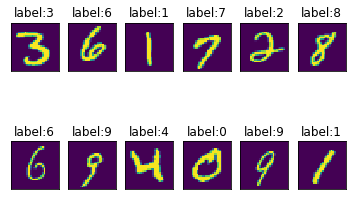

In [0]:
def preview(data,result):
  """Shows 12 elements of picture dataset"""
  fig = plt.figure()
  for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(data[i], interpolation='none')
    plt.title("label:{}".format(result[i]))
    plt.xticks([])
    plt.yticks([])

preview(X_train[12:],y_trn[12:])

###Build Model
In order to tune the parameters of our Keras model using scikit-learn we need to be able to rebuild our model using different parameters. To do this, we create a function to build the model based on our hyper parameters:


In [0]:
def build_model(var_activation='relu',var_optimizer='adam'):
  """ Builds and compiles Keras model using arguments for activation function and optimizer."""
  model = Sequential()
  model.add(Flatten(input_shape=[28, 28, 1]))
  model.add(Dense(64,activation=var_activation))
  model.add(Dense(32,activation=var_activation))
  model.add(Dense(16,activation=var_activation))
  model.add(Dense(10,activation='softmax'))
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=var_optimizer,
                metrics=["accuracy"])
  return model

This is how our model looks with default parameters:

In [0]:
model_default = build_model()
model_default.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                170       
Total params: 53,018
Trainable params: 53,018
Non-trainable params: 0
_________________________________________________________________


###Set variables
We want to test model’s performance using Adam algorithm and Stochastic Gradient Descent as well as test different activation functions for the layers and batch sizes for training the model. Let’s create lists of our parameters and store them as a dictionary. The keys in the dictionary are the names of variables that are used in our model:

In [0]:
_activations=['tanh','relu','selu']
_optimizers=['sgd','adam']
_batch_size=[16,32,64]
params=dict(var_activation=_activations,var_optimizer=_optimizers,batch_size=_batch_size)
print(params)

{'var_activation': ['tanh', 'relu', 'selu'], 'var_optimizer': ['sgd', 'adam'], 'batch_size': [16, 32, 64]}


Note that ‘batch_size’ is not a variable in the build_model function, but rather the variable that would be used later in the .fit() call to train the model we create.

In [0]:
#model_default.fit(X_trn,y_trn,batch_size=16,epochs=1)

###Create a scikit learn estimator from the Keras model
Now that we have the data, the function to build our models and the parameters we want to test, we can use the sklearn library to test different models based on our function and hyper parameters. We can use the GridSearchCV or the RandomizedSearchCV objects from the sklearn.model_selection module to iterate through different combinations of our hyper parameters and output the model with the best score. The GridSearchCV object will iterate through all possible combinations of hyper parameters, while the RandomizedSearchCV object will randomly sample a number of possible combinations to train the model. While using randomized search may not always provide best possible model, it is much faster and less resource intensive since not all combinations of parameters are considered. This makes randomized model search very useful for testing and prototyping.
To use RandomizedSearchCV we first need to make our Keras model compatible with sklearn library and we will use keras wrapper for scikitlearn: KerasClassifier.


In [0]:
model = KerasClassifier(build_fn=build_model,epochs=4,batch_size=16)

Before fitting our RandomizedSearch object we set the random seed with the numpy.random.seed(). Setting the seed to the random number generator will make our model weights initialization the same for each iteration making our search more meaningful. If our hyper parameters include number of layers or number of nodes in a layer however, this will be of little help because we will be comparing entirely different models.

In [0]:
np.random.seed(42)

###Use RandomizedSearchCV to find best combination of hyper parameters
Once we have created the KerasClassifier, we the create the RandomizedSearchCV object and use the .fit() method to start searching for the best model. RandomizedSearchCV allows us to explicitly control the number of combinations to try using the parameter n_iter.


In [0]:
rscv = RandomizedSearchCV(model,param_distributions=params,cv=3,n_iter=10)
rscv_results = rscv.fit(X_trn,y_trn)

Here are the results of our search:

In [0]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,rscv_results.best_params_))

Best score is: 0.9578499992688497 using {'var_optimizer': 'adam', 'var_activation': 'tanh', 'batch_size': 32}


###Conclusion
Hyper parameter tuning can be used to fine tune a selected model or to search for a model best suited for the task. It can also help evaluate how fast the model is learning.
The approach above can be expanded further to include a more exhaustive search using GridSearchCV object from scikit-learn library, or by adding parameters for the structure of our model such as number of layers. Callbacks can be added to prevent overfitting tested models.